In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./TRPO/')

In [39]:
import json
import argparse
from itertools import count

import gymnasium as gym
import scipy.optimize

import torch
from models import *
from replay_memory import Memory
from running_state import ZFilter
from torch.autograd import Variable
from trpo import trpo_step
from utils import *
import random
import matplotlib.pyplot as plt
import sys

In [3]:
sys.path.append('./CityLearn/')
# from citylearn.my_citylearn import CityLearnEnv
from citylearn.gen_citylearn import CityLearnEnv

wandb_record = False
if wandb_record:
    import wandb
    wandb.init(project="TRPO_rl")
    wandb.run.name = "test_my_env"
wandb_step = 0


In [5]:
torch.utils.backcompat.broadcast_warning.enabled = True
torch.utils.backcompat.keepdim_warning.enabled = True

torch.set_default_tensor_type('torch.DoubleTensor')

parser = argparse.ArgumentParser(description='PyTorch actor-critic example')
parser.add_argument('--gamma', type=float, default=0.995, metavar='G',
                    help='discount factor (default: 0.995)')
parser.add_argument('--env-name', default="HalfCheetah-v4", metavar='G',
                    help='name of the environment to run')
parser.add_argument('--tau', type=float, default=0.97, metavar='G',
                    help='gae (default: 0.97)')
parser.add_argument('--l2-reg', type=float, default=1e-3, metavar='G',
                    help='l2 regularization regression (default: 1e-3)')
parser.add_argument('--max-kl', type=float, default=1e-2, metavar='G',
                    help='max kl value (default: 1e-2)')
parser.add_argument('--damping', type=float, default=1e-1, metavar='G',
                    help='damping (default: 1e-1)')
parser.add_argument('--seed', type=int, default=543, metavar='N',
                    help='random seed (default: 1)')
parser.add_argument('--batch-size', type=int, default=15000, metavar='N',
                    help='random seed (default: 1)')
parser.add_argument('--render', action='store_true',
                    help='render the environment')
parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                    help='interval between training status logs (default: 10)')
 

parser.add_argument('--data-path', default='./CityLearn/citylearn/data/gen_data/', help='data schema path')
args = parser.parse_args('')

schema_filepath = args.data_path+'schema.json'
eval_schema_filepath = args.data_path+'schema_eval.json'


env = CityLearnEnv(schema_filepath)



In [27]:
[e for e in env.schema['observations'] if env.schema['observations'][e]['active'] ]

['month',
 'hour',
 'non_shiftable_load',
 'solar_generation',
 'electrical_storage_soc',
 'net_electricity_consumption',
 'electricity_pricing']

In [29]:
env = CityLearnEnv(schema_filepath)
# env = gym.make(args.env_name)

num_inputs = env.observation_space[0].shape[0]
num_actions = env.action_space[0].shape[0]

num_inputs, num_actions
building_count = len(env.buildings)
building_count, num_inputs, num_actions

(5, 7, 1)

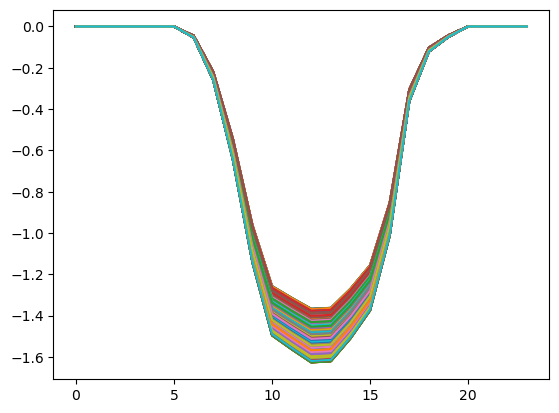

In [63]:
random.seed(0)
idx = 0
loads = []
solars = []
scatter = []
for j in range(1000):
    load_random = [random.random()*0.9+0.1 for i in range(building_count)]
    solar_random = [random.random()*0.4+2.1 for i in range(building_count)]
    loads.append(load_random[idx])
    solars.append(solar_random[idx])
    state = env.reset(load_random,solar_random);
    done = False
    states = [state]
    while not done:
        state, reward, done, info = env.step(actions=[0.1,0.2,0.3,0.1,.1])
        states.append(state)
    
    scatter .append([solar_random[idx],states[12][idx][3]])    
    states = np.array(states)
    plt.plot(states[:,idx,3])

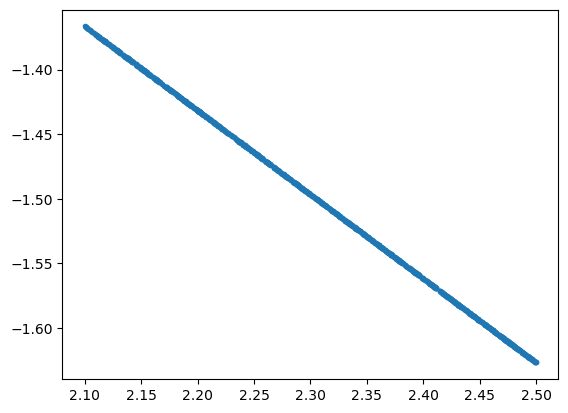

In [62]:
scatter = np.array(scatter)
plt.plot(scatter[:,0],scatter[:,1],'.')

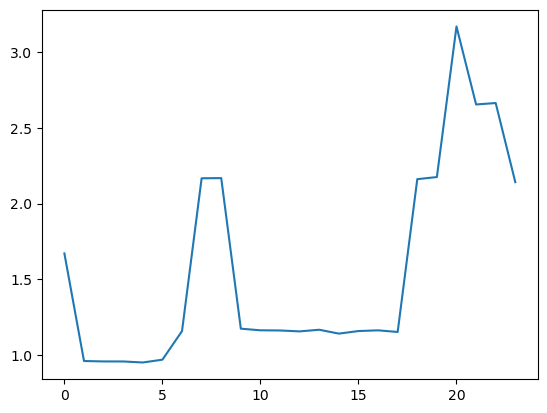